In [98]:
from datasets.libri_dataset import get_test_dataloader, get_train_dataloader
from datasets.config import config_dataloader

from model.spex_plus import SpEx_Plus
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm


In [99]:
torch.manual_seed(42)
np.random.seed(42)

In [100]:
device = "cuda"
checkpoint_path = "/home/m4xig1/speaker_extraction_SpEx/checkpoints/best_steam.pth"

In [101]:
dataloader, _ = get_train_dataloader(config_dataloader) # трейновый возвращает число спикеров!!
model = SpEx_Plus()
checkpount = torch.load(checkpoint_path, device)
model.load_state_dict(checkpount["state_dict"])
model = model.to(device)


In [102]:
def move_batch_to_device(batch: dict, device: torch.device):
    for key in batch.keys():
        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].to(device)
    return batch

In [103]:
embeddings = []
speaker_ids = []
max_iters = 2000
with torch.no_grad():
    for batch_idx, batch in tqdm(
        enumerate(dataloader),
        desc="val",
        total=len(dataloader),
    ):
        batch = move_batch_to_device(batch, device)
        embedding, _ = model.calculate_speaker_embadding(batch["reference"], batch["ref_len"], internal=False)
        embeddings.append(embedding.cpu().numpy())
        speaker_ids.append(batch["speaker_id"].item())
        if (batch_idx > max_iters):
            break

val:   6%|▋         | 2001/31335 [01:45<25:51, 18.91it/s]  


In [104]:
embaddings = np.array(embeddings).squeeze(1)

In [114]:
tsne = TSNE(n_components=2, perplexity=30)
embeddings_2d = tsne.fit_transform(embaddings)


/tmp/ipykernel_24666/940684098.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("tab20", len(uni_spk))


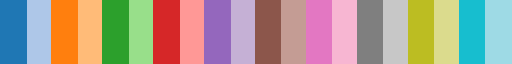

In [115]:
import matplotlib.cm as cm

uni_spk = list(set(speaker_ids))
colormap = cm.get_cmap("tab20", len(uni_spk))
colormap

/tmp/ipykernel_24666/2912140492.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("tab20", len(uni_spk))
/tmp/ipykernel_24666/2912140492.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


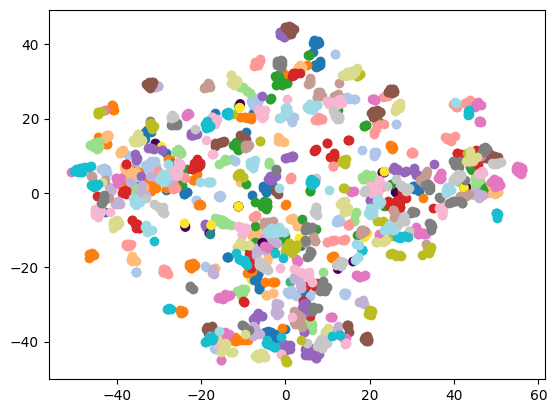

In [116]:
import matplotlib.cm as cm

uni_spk = list(set(speaker_ids))

colormap = cm.get_cmap("tab20", len(uni_spk))

fig, ax = plt.subplots()
for speaker_id in uni_spk:
    speaker_indices = [i for i, s_id in enumerate(speaker_ids) if s_id == speaker_id]
    ax.scatter(
        embeddings_2d[speaker_indices, 0],
        embeddings_2d[speaker_indices, 1],
        c=colormap(uni_spk.index(speaker_id)),
        label=f"Speaker {speaker_id}",
    )

# ax.legend()
plt.show()